In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
import bs4 
from ipywidgets import interact,IntSlider,interactive,HBox
from IPython.display import display
import random
import time
import threading
from pprint import pprint
import requests
import csv

# Data retrieval
First of all, we need to retrieve the data from the simulation. For that, we first run the below script. It runs the simulation for every possible loads (request/s), first for 1 AP and 1 server, then for 1 AP and 2 server, and so on. Each measure is made 3 times, to avoid at most some "unlucky" or "too lucky" simulation that would distort the analysis.

In [2]:
NUM_THREADS = 10
URL = "http://tcpip.epfl.ch/output.php"


class MyThread(threading.Thread):
    """
    Subclass to threading.Thread for multithreading purpose.
    """

    def __init__(self, ap, servers, thread_id):
        super().__init__()
        self.ap = ap
        self.servers = servers
        self.thread_id = thread_id
        self.data = []
        self.client=0

    def run(self):
        for self.client in range(1,1001):
            payload = {"sciper":"236079", 
                       "clients":self.client, 
                       "apoints":self.ap, 
                       "servers":self.servers}
            for k in range(3): #take each measure 3 times          
                resp = requests.post(URL, data=payload)
                soup = bs4.BeautifulSoup(resp.content)
                table = soup.find("table") 
                rows = table.find_all("tr")
                data_point = []
                for row in rows:
                    cols = row.find_all("td")
                    cols = [ele.text.strip() for ele in cols]
                    if not "values" in cols[0]:
                        data_point.append(cols)
                self.data.append(data_point)
            if self.client%100 == 0:
                print("[{}] {} - {} - {}".format(self.thread_id, 
                                                 self.ap, 
                                                 self.servers,
                                                 self.client))

    def join(self):
        super().join()
        return self.data

try:
    df = pd.read_csv('pandas_data.csv', index_col="index")
    df['Access points'] = pd.to_numeric(df['Access points']) 
    df['Servers'] = pd.to_numeric(df['Servers'])
    empty=False
except FileNotFoundError:
    df = pd.DataFrame()
    empty=True
for ap in range(1,11): #for each AP configuration
    threads_list = []
    for num_thread in range(NUM_THREADS):
        #assign a thread to a count of servers
        servers = num_thread+1
        if not empty:
            specific_df = df[(df['Servers'] == servers) & 
                             (df['Access points'] == ap)]
            if len(specific_df) >= 1000:
                #if already enough data, don't launch thread
                print("ignoring combination {}-{}".format(ap,servers))
                continue
        print("Launching new thread for {} AP and {} servers".format(ap, servers))
        thread = MyThread(ap, servers, num_thread)
        thread.start()
        threads_list.append(thread)

    #Join threads
    for thread in threads_list:
        print("Joining thread {}".format(thread.thread_id))
        data = thread.join()
        #read joined data, and append to current DataFrame
        for i in data:
            df = df.append(pd.Series([x[1] for x in i], [x[0] for x in i]), 
                           ignore_index=True)
        #save intermediate result
        df.to_csv("pandas_data.csv", index_label="index")

ignoring combination 1-1
ignoring combination 1-2
ignoring combination 1-3
ignoring combination 1-4
ignoring combination 1-5
ignoring combination 1-6
ignoring combination 1-7
ignoring combination 1-8
ignoring combination 1-9
ignoring combination 1-10
ignoring combination 2-1
ignoring combination 2-2
ignoring combination 2-3
ignoring combination 2-4
ignoring combination 2-5
ignoring combination 2-6
ignoring combination 2-7
ignoring combination 2-8
ignoring combination 2-9
ignoring combination 2-10
ignoring combination 3-1
ignoring combination 3-2
ignoring combination 3-3
ignoring combination 3-4
ignoring combination 3-5
ignoring combination 3-6
ignoring combination 3-7
ignoring combination 3-8
ignoring combination 3-9
ignoring combination 3-10
ignoring combination 4-1
ignoring combination 4-2
ignoring combination 4-3
ignoring combination 4-4
ignoring combination 4-5
ignoring combination 4-6
ignoring combination 4-7
ignoring combination 4-8
ignoring combination 4-9
ignoring combination 4

## Results exploration

In [3]:
df.head()

,Access points,Collision probability,Delay,Packets per second,Requests per second,Sciper ID provided,Servers,Theta
index,,,,,,,,
0,1,0.000013,0.143996,3.245,1,236079,1,0.972
1,1,0.000012,0.115127,0.000,1,236079,1,0.944
2,1,0.000014,0.123098,0.000,1,236079,1,0.993
3,1,0.000014,0.147046,3.894,2,236079,1,1.943
4,1,0.000013,0.138540,9.439,2,236079,1,1.883


In [4]:
df.describe()

,Access points,Collision probability,Delay,Packets per second,Requests per second,Sciper ID provided,Servers,Theta
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.0,300000.000000,300000.000000
mean,5.500000,0.279587,155.781832,2176.337510,500.500000,236079.0,5.500000,404.318171
std,2.872286,0.419075,333.378683,1284.483024,288.675471,0.0,2.872286,249.965069
min,1.000000,0.000009,0.021352,0.000000,1.000000,236079.0,1.000000,0.930000
25%,3.000000,0.000261,0.623686,1206.448750,250.750000,236079.0,3.000000,197.328750
50%,5.500000,0.006141,2.555264,2039.977000,500.500000,236079.0,5.500000,366.695500
75%,8.000000,0.783901,30.798532,3120.555750,750.250000,236079.0,8.000000,588.684000
max,10.000000,1.000000,1082.849096,5523.136000,1000.000000,236079.0,10.000000,999.000000


# Question 1

Clearly, making the same simulation multiple times will not yield every time the same results. As we can see two cells above, the "simplest" case (1 AP, 1 server, 1 request/second) yields different outputs (e.g. delays of 5.288, 11.005 and 0). As in every simulation, there are a lot of hidden factors at play. Hopefully, they are nothing but nuisance factors, and only create a small variance in every result, that is evenly distributed in each simulation. 

# Question 2

First, we need to make a script to easily plot and visualize the representation

In [5]:
def plot_comparison(df, nums_servers, nums_aps):
    """
    Plots multiple configurations on a single figure
    
    Example:
        plot_comparison(df, [1,2], [3,4]) will create a graph with 2 configuration: 
        first with 1 server and 3 access points, 
        second with 2 servers and 4 access points.
    
    args:
    df -- pandas.DataFrame: dataframe where to select the data
    nums_servers -- list[int]: numbers of servers for each 
        configuration to display (order matters)
    nums_aps -- list[int]: numbers of access points for each
        configuration to display
    """
    
    if len(nums_servers) != len(nums_aps):
        print("Error, length of configurations must be the same")
        return
    
    ylabel = {
        "Theta": "Theta [requests/s]",
        'Collision probability': "Collision probability [%]",
        'Delay': "Delay [ms]",
        'Packets per second': "Packets per second [packets/s]"
    }
    
    fig = plt.figure(figsize=(15,10))
    for num, metric in enumerate(ylabel): #iterate through metrics
        fig.add_subplot(2,2,num+1)
        #iterate through configurations
        for serv, ap in zip(*(nums_servers, nums_aps)):
            #get data
            df_temp = df[(df['Servers'] == serv) & (df['Access points'] == ap)] 
            plt.scatter(df_temp['Requests per second'], 
                        df_temp[metric] * (100 if "Collision" in metric else 1), 
                        s=0.5, 
                        label="{} serv / {} AP.".format(serv, ap))
        
        if metric == "Theta":
            # plot ideal theta line if needed
            plt.plot(np.arange(1000), label="Ideal Theta")
        
        plt.title("{}".format(metric))
        plt.ylabel(ylabel[metric])
        plt.xlabel("Load [requests/s]")
        plt.legend(markerscale=9.)
    plt.tight_layout()

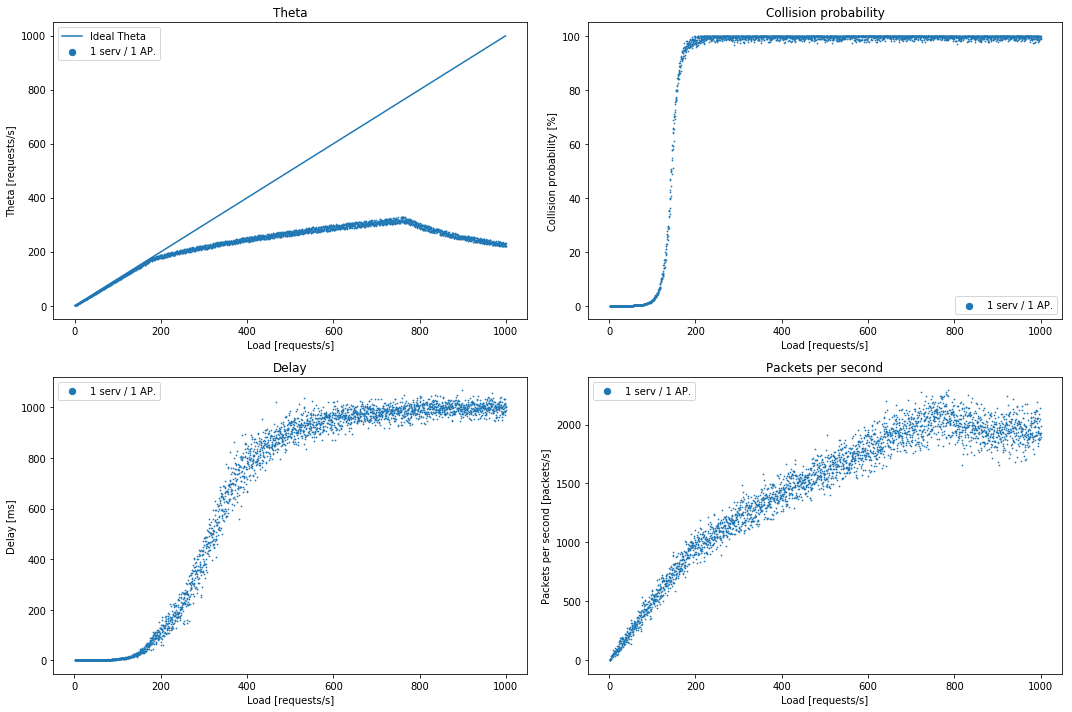

In [6]:
plot_comparison(df, [1], [1])

## First observations

### Delay

We see that the delay first is consistently small, then grows exponentially until reaching an horizontal asymptote. The asymptote is at 1'000 ms, because above that the request is dropped, otherwhise we would have an ever increasing load (as each request is re-made every second). Ideally, we would like to keep the delay as low as possible (ideally close to 0)

### Collision probability

As before, the collision probability is close to 0%, but at some threshold (between 120 and 160 requests/s) it explodes and comes consistently close to 100%. Again, we are wishing for a probability close to 0%


### Theta



As expected, the number of requests served is linear and follows the "ideal" line: (almost) as many requests per second are queried and served.
But once a threshold around 200 is reached, the delay augments (see 3rd plot), and thus the number of served requests per seconds can't follow the load.
Finally, a second threshold around 800 is reached, and now the server is under too much pressure, and can't handle it: requests get dropped, but too much is lost in overhead. The service is degrading proportionally to the load, reaching the asymptote at 200 (the "max" it can handle)

## Conclusions

It is hard to conclude anything serious with only one configuration. What we see, is that between 180 and 200 requests per second, everything starts to break and takes a new form. We'd need a second configuration to see which factor is a bottleneck at 180 requests/s.

# Question 3

Now we compare our first results with a second configuration: still one server, but 2 access points.

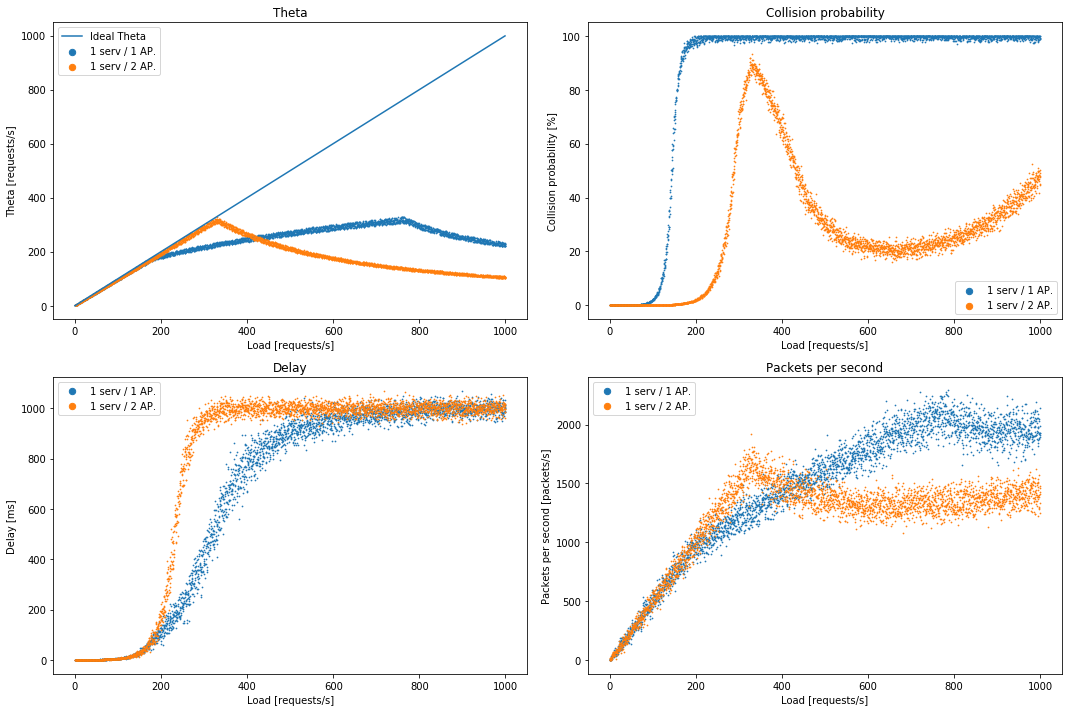

In [7]:
plot_comparison(df, nums_servers=[1,1], nums_aps=[1,2])

This yields a lot of information. 
 * First of all, the least surprising result: the collision probability never reaches the same heights as before. It "only" goes up to 90%, then goes down. This is typical to a CSMA/CD protocol, where when a collision is detected, the first sender will wait for some time to avoid future collision.
 * This is coherent with the _Delay_ graph, showing a greater delay: when a collision is detected, the access point will wait until it can transmit again. The delay is thus going up quicker, but the collision stays low.
 * From ~600 requests/second, the collision probability starts going up, as the delay is already too high and the protocol will transmit again, ignoring the collisions.

So doubling the number of access points is not an perfect solution, but we do have some enhancements. 

Only from this, we can suppose that 
 * with more access points, the theta grows for longer before "crashing",
 * The delay augments with the access points,
 * Packets/s grow linearly for longer, but "crash harder" when their limit is reached,
 * Collision probability benefits more access points.

We try to those claims with some more simulations:

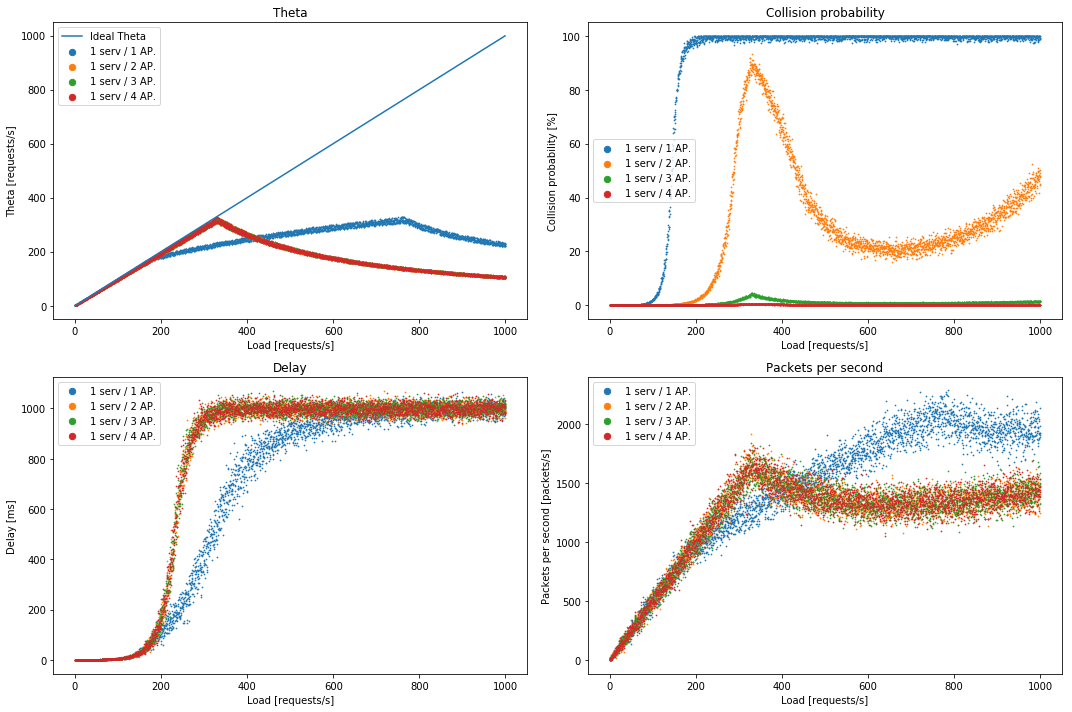

In [8]:
plot_comparison(df, [1,1,1,1], [1,2,3,4])

It becomes clear that more access points will decrement the collision probability goes down, no matter what. But if one more access points "unlocked" some performances, they are now locked, probably bottlenecked by the server count, as every access point count > 1 follows the same performances in all the metrics (except collision probability)

In order to understand better, we plot two new configurations to compare: 2 servers / 1 AP and 2 servers / 2 AP

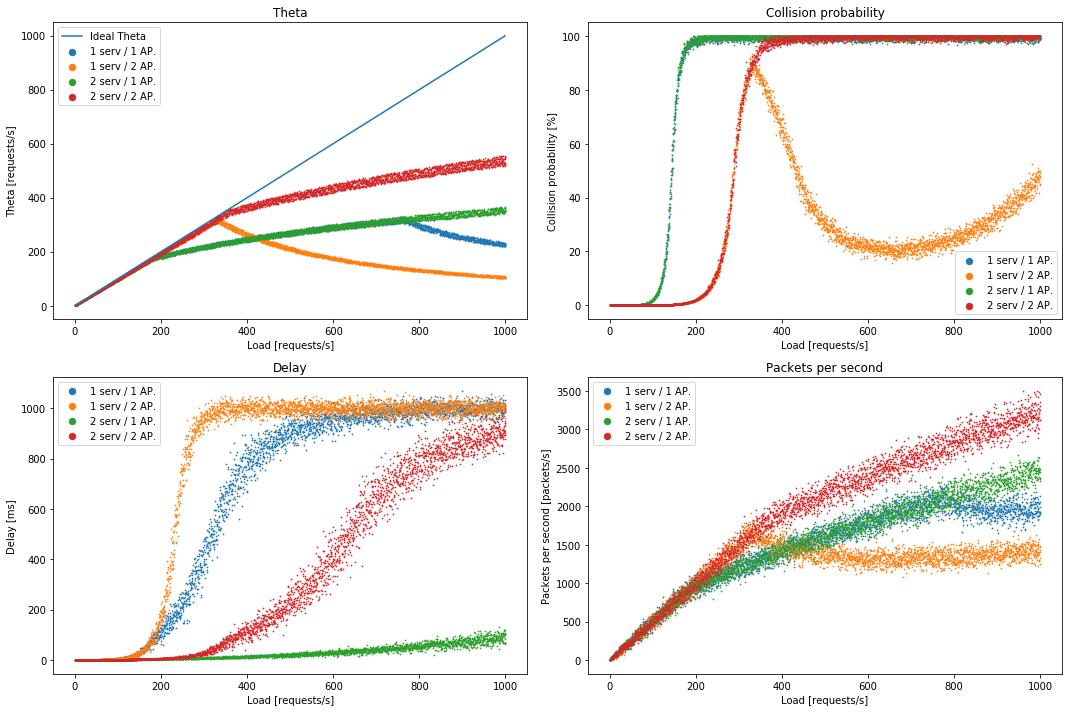

In [9]:
plot_comparison(df, [1,1,2,2], [1,2,1,2])

With this, we can draw some thumb rules:
 * A server can serve up to ~380 requests per second
 * But an AP can only serve ~190 requests per second

The other interesting observation we can do, is that the green configuration has the same collision probablity than the blue one. So this is not a function of the servers number, but only the access points (as already asserted before)

Then, we see in the _Delay_ graph that the "heaviest" solution (2 AP and servers) does not lead to the best result. The more servers compared to the number of AP, the least delay we'll obtain,

# Question 4

So, only looking at the Theta above, we'd need about $\frac{requests/s}{380}$ servers, and twice as many access points. So in the worst case, we'd need about 1000/380 $\simeq$ 3 servers and 6 access points.

But the above configuration will lead to high collision probability and delay in higher loads. They stay at acceptable levels (as they don't influence the Theta and Packets/s), but we way want to reduce them nonetheless. For this, we need to add more servers to reduce the delay, and AP to reduce the collision probability.

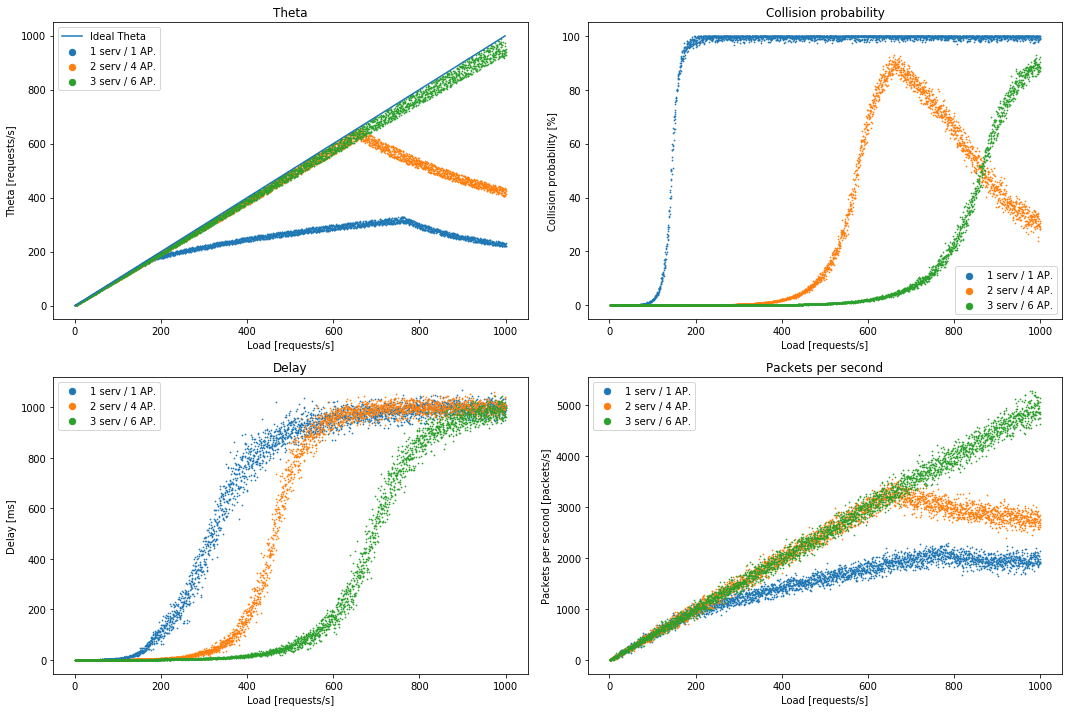

In [10]:
plot_comparison(df, [1,2,3], [1,4,6])

Indeed, the green configuration seems to cover the needs in terms of Theta. and packets/s
The orange configuration is mainly sufficient for 600 requests/s, as predicted. 

To reduce some delay, we can add servers. We take the orange configuration as a reference.

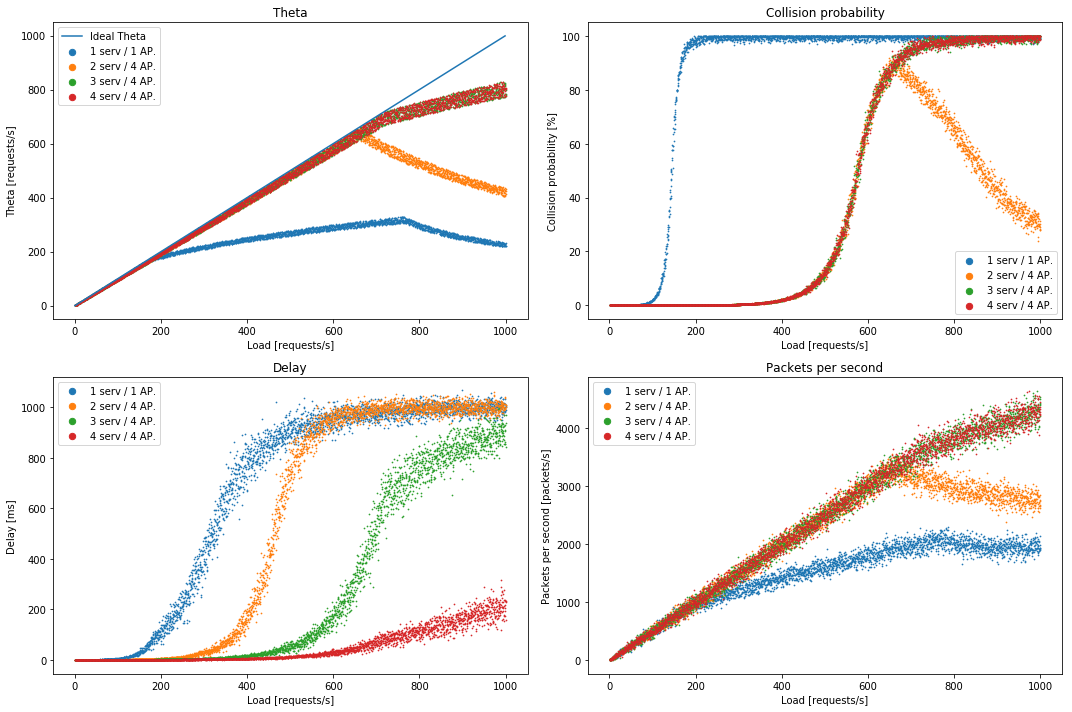

In [11]:
plot_comparison(df, [1,2,3,4], [1,4,4,4])

As predicted the delay has gone down with the number of servers, while the collision probability barely changes. Only change there: at the "break point" of our orange reference configuration, instead of absorbing the collisions and going down, it stays high.

Varying the count of access points (in reference to our 2 serv / 4 AP configuration), we obtain the following results:

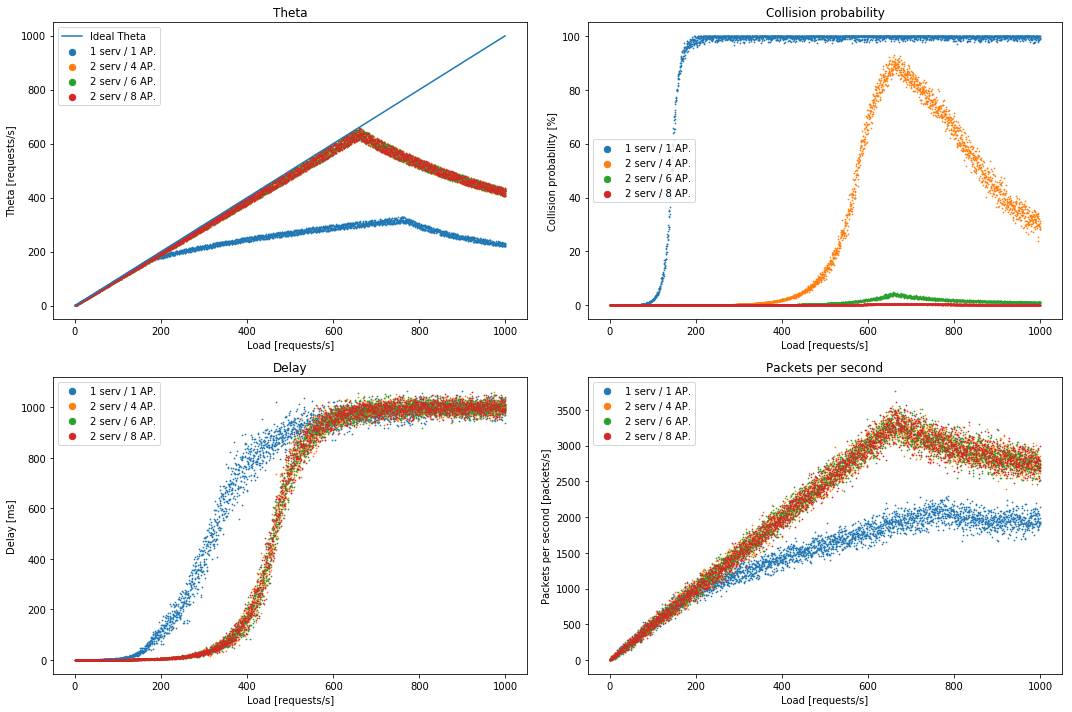

In [12]:
plot_comparison(df, [1,2,2,2], [1,4,6,8])

Which matches our expectations.

# Conclusion

The engineering rule we can give to Joe, is our rule from above:
$$\# servers = \frac{load}{380} \ \ \ AP = 2\cdot servers$$
This is the minimal configuration to have the maximum _throughput_ (Theta and packets/s). If Joe wished to reduce the delay of each request, he can then augment the number of servers, and if he wishes to reduce the collision probability, he can augment the count of access points.

# Bonus: slider of sliders to compare configurations


In [13]:
@interact(n_weights=(1,7,1))
def nice_plotter(n_weights):
    weight_sliders = [(IntSlider(
            value=1,
            min=1,
            max=10,
            step=1,
            description='serv config %d' % i,
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True
        ), IntSlider(
            value=1,
            min=1,
            max=10,
            step=1,
            description='AP config %d ' % i,
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True
        )) for i in range(n_weights)]
    serv_kwargs = {'server{}'.format(i):s_slider
                   for i, (s_slider, _) in enumerate(weight_sliders)}
    ap_kwargs = {'ap{}'.format(i):ap_slider 
                 for i, (_, ap_slider) in enumerate(weight_sliders)}
    kwargs = {**serv_kwargs, **ap_kwargs}

    def wrapper(**kwargs):
        serv = [kwargs[x] for x in kwargs if 'server' in x]
        ap = [kwargs[x] for x in kwargs if 'ap' in x]
        plot_comparison(df, serv, ap)

    ip = interactive(wrapper, **kwargs)
    for i in range(n_weights):
        display(HBox([ip.children[i], # show controls in pairs
                      ip.children[(i+n_weights)%(n_weights*2)]])) 
    display(ip.children[-1])#Show the output

interactive(children=(IntSlider(value=4, description='n_weights', max=7, min=1), Output()), _dom_classes=('wid…